# *Modeling Part: XGBoost*

****************************************************************************************************************************************

In [1]:
import pandas as pd
import  numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
import xgboost as xgb
from sklearn import metrics
from sklearn.metrics import accuracy_score


In [2]:
url_final = 'https://dl.dropboxusercontent.com/scl/fi/ep8vuirz46gkhw4a3yfw6/final_dataset.csv?rlkey=b9ji5utoaahhkmsoebup6q95q&dl=1'
df_final = pd.read_csv(url_final)

In [3]:
df_final.shape

(284700, 25)

In [4]:
df_final.head()

,COIL,MT_ADJUSTED,DATE,TIME_START_PROCESS,TEMP_Z1,PYRO_2_FRST_3_ZONE,SPEED_PROCESS,FILL_TIRO,LASER_FRN_1,ELET_FE2,...,LASER_FRN_9,DEC_FE2,DEC_FE3,LASER_FRN_8,SPZ1_R1_ASS,FRN_FURNACE_PRESSURE,AIR_CH4_1,FILL_FORZA,PRES_ZONA3_MEASURED,Has_Defect
0,297712,0.0,2019-03-03,16:00:17.140,-0.626250,0.589075,-1.749652,-0.003943,1.130454,-0.024409,...,-0.921559,-0.019089,0.006705,-3.281993,-0.005561,3.480863,5.618876,-0.006274,-0.362265,0.0
1,297712,7.0,2019-03-03,16:01:02.140,-0.548642,0.310833,-1.423870,-0.003943,1.167358,-0.024409,...,-0.882066,-0.019089,0.006705,-3.286931,-0.005561,4.155847,5.606975,-0.006274,-3.121354,0.0
2,297712,14.0,2019-03-03,16:01:32.140,-0.489710,0.219359,-1.249998,-0.003943,1.169191,-0.024409,...,-0.895256,-0.019089,0.006705,-3.283506,-0.005561,3.724010,5.505825,-0.006274,-2.903597,0.0
3,297712,21.0,2019-03-03,16:01:47.080,-0.472777,0.560960,-1.250524,-2.503042,1.183099,-0.024409,...,-0.888345,-0.019089,0.006705,-3.239610,-0.005561,3.202527,5.599273,-1.168397,-2.357400,0.0
4,297712,28.0,2019-03-03,16:02:17.080,-0.457463,0.437551,-1.250053,-2.717672,1.189643,-2.331214,...,-0.887054,-2.294722,1.560311,-3.249343,-0.574788,2.952983,5.556279,-1.176393,-1.833425,0.0


**'df_final'** is now our final dataframe with the selected features and the target column of interest ('Has_Defect') at the end

#### Splitting our data into Train, Validation and Test sets

To ensure that the same coils are not split across both the training and testing sets, thereby preventing data leakage, we need to stratify the split based on the coil ID. This means we should split our dataset in such a way that all records belonging to a specific coil are either entirely in the training set or entirely in the testing set

In [5]:
# Get unique coil IDs and split them
unique_coils = df_final['COIL'].unique()
train_coils, test_coils = train_test_split(unique_coils, test_size=0.2, random_state=42)
train_coils, val_coils = train_test_split(train_coils, test_size=0.25, random_state=42)  # Splitting the remaining 80% into 60% train and 20% validation

# Split the DataFrame into training, validation, and testing sets based on coil IDs
train_df = df_final[df_final['COIL'].isin(train_coils)]
val_df = df_final[df_final['COIL'].isin(val_coils)]
test_df = df_final[df_final['COIL'].isin(test_coils)]


In [6]:
target = "Has_Defect"

# Prepare the data
X_train = train_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)  
y_train = train_df[target]    

X_val = val_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)
y_val = val_df[target]

X_test = test_df.drop(['COIL', 'MT_ADJUSTED', 'DATE', 'TIME_START_PROCESS', target], axis=1)   
y_test = test_df[target]     

### XGBoost

In [7]:
param_grid = {
    'n_estimators': [100, 200],  # Number of gradient boosted trees.
    'learning_rate': [0.05, 0.1],  # Step size shrinkage used to prevent overfitting.
    'max_depth': [3, 5],  # Maximum tree depth for base learners.
    'min_child_weight': [1, 2],  # Minimum sum of instance weight needed in a child.
    'gamma': [0, 0.1],  # Minimum loss reduction required to make a further partition.
    'subsample': [0.8, 1.0],  # Subsample ratio of the training instances.
    'colsample_bytree': [0.8, 1.0],  # Subsample ratio of columns when constructing each tree.
}


# Create the XGBoost classifier instance
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, 
                           scoring='accuracy', cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# After grid search completes
print(f"Best parameters found: {grid_search.best_params_}")
best_xgb_clf = grid_search.best_estimator_

Fitting 3 folds for each of 128 candidates, totalling 384 fits


Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 2, 'n_estimators': 100, 'subsample': 0.8}


In [9]:
# Predict on the validation set
y_val_pred_xgb = best_xgb_clf.predict(X_val)
# Calculate the accuracy of the model on the validation set
val_acc_xgb = accuracy_score(y_val, y_val_pred_xgb)
print(f"Validation Accuracy XGBoost: {val_acc_xgb}\n")
# Print out the classification report which provides a summary of the model's performance
print("**Classification report for XGBoost Classifier on the validation set:**\n")
print(classification_report(y_val, y_val_pred_xgb))

# Make predictions on the test set using the best model
y_test_pred_xgb = best_xgb_clf.predict(X_test)
# Calculate the accuracy of the model on the test set
test_acc_xgb = accuracy_score(y_test, y_test_pred_xgb)
print(f"Testing Accuracy XGBoost: {test_acc_xgb}\n")
# Print out the classification report which provides a summary of the model's performance
print("**Classification report for XGBoost Classifier on the test set:**\n")
print(classification_report(y_test, y_test_pred_xgb))

Validation Accuracy XGBoost: 0.7710627135609015

**Classification report for XGBoost Classifier on the validation set:**

              precision    recall  f1-score   support

         0.0       0.81      0.84      0.83     37618
         1.0       0.69      0.63      0.66     20328

    accuracy                           0.77     57946
   macro avg       0.75      0.74      0.74     57946
weighted avg       0.77      0.77      0.77     57946

Testing Accuracy XGBoost: 0.7605284602181112

**Classification report for XGBoost Classifier on the test set:**

              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82     39859
         1.0       0.61      0.64      0.62     17818

    accuracy                           0.76     57677
   macro avg       0.72      0.73      0.72     57677
weighted avg       0.76      0.76      0.76     57677



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


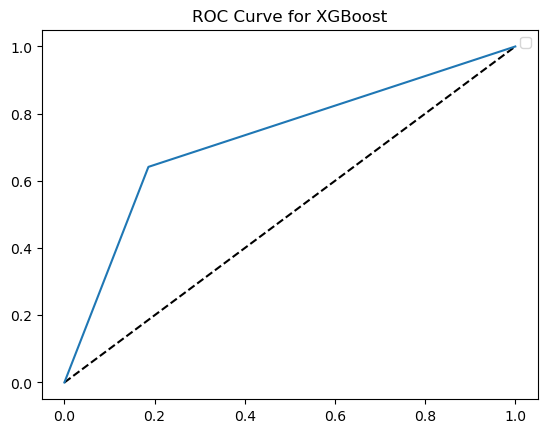

In [11]:
# Plot the ROC curve for XGBoost 
fpr_xgboost, tpr_xgboost, _ = metrics.roc_curve(y_test, y_test_pred_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_xgboost, tpr_xgboost)
plt.title('ROC Curve for XGBoost')
plt.legend()
plt.show()

In [15]:
# Features importances of the model
feature_importances_xgb = best_xgb_clf.feature_importances_
# Summary of feature importance
summary_imp = pd.DataFrame(list(zip(X_train.columns, feature_importances_xgb)), columns=["Feature", "Importance"])
summary_imp = pd.DataFrame(summary_imp.sort_values(by="Importance", ascending=False))
print("Summary of feature importance:")
print(summary_imp)


Summary of feature importance:
                 Feature  Importance
1     PYRO_2_FRST_3_ZONE    0.200912
0                TEMP_Z1    0.130596
3              FILL_TIRO    0.075202
18            FILL_FORZA    0.073146
9            LASER_FRN_2    0.058435
10              FILL_ALL    0.050662
13               DEC_FE3    0.047217
7             ELET_H2SO4    0.037822
8                  EXT_1    0.036779
15           SPZ1_R1_ASS    0.035797
11           LASER_FRN_9    0.034885
6              DEC_H2SO4    0.032140
19   PRES_ZONA3_MEASURED    0.029763
5               ELET_FE2    0.028928
17             AIR_CH4_1    0.028727
4            LASER_FRN_1    0.028459
2          SPEED_PROCESS    0.022270
16  FRN_FURNACE_PRESSURE    0.021274
14           LASER_FRN_8    0.014534
12               DEC_FE2    0.012452


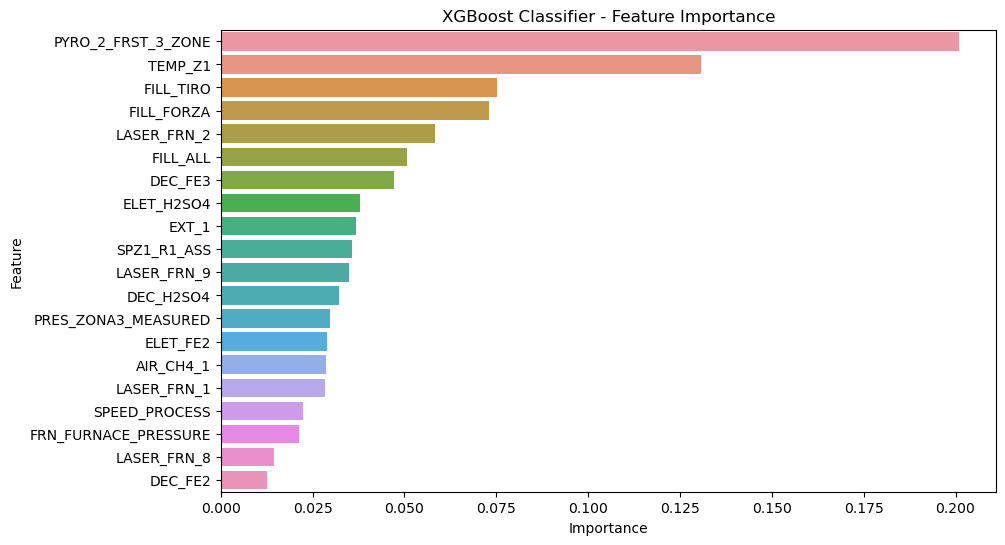

In [16]:
plt.figure(figsize=(10, 6))
sns.barplot(x=summary_imp["Importance"], y=summary_imp["Feature"])
plt.title('XGBoost Classifier - Feature Importance')
plt.show()